Natural Language Processing with Disaster Tweets

objective-  Predict which Tweets are about real disasters and which ones are not

 Description


Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).


But, it’s not always clear whether a person’s words are actually announcing a disaster.


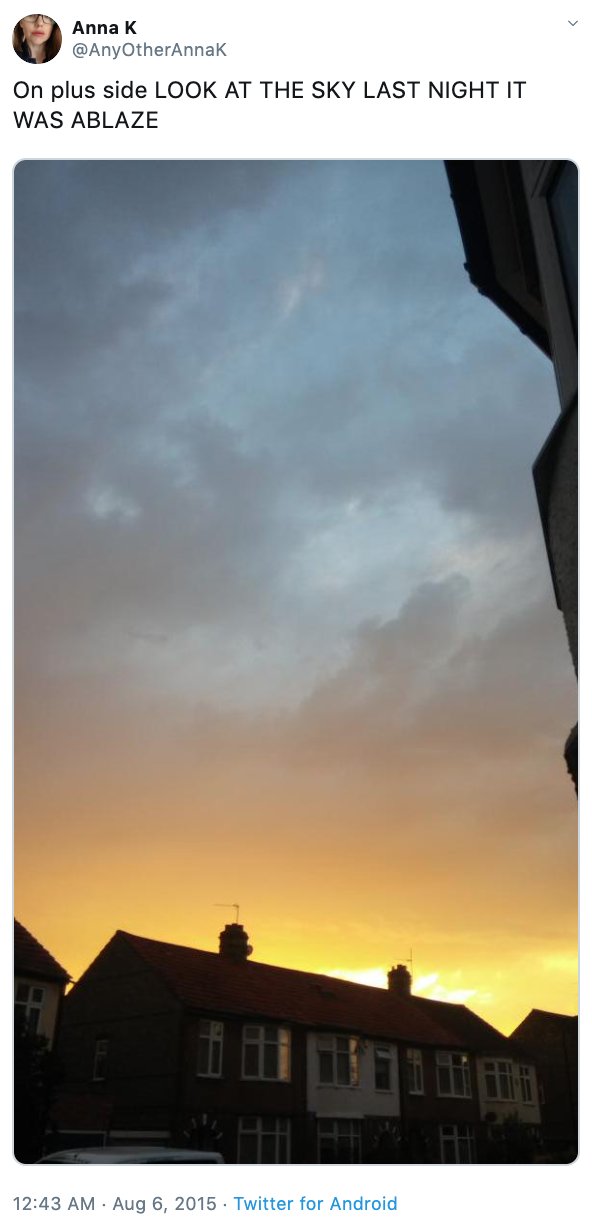

Import libraries

In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
from wordcloud import WordCloud

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_metadata as metadata
#from tensorflow import keras
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from nltk import compat
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer, TFBertModel


loading dataset

In [3]:
sample_submission_data = pd.read_csv('/content/sample_submission[1].csv')
train_data = pd.read_csv('/content/train[1].csv')
test_data = pd.read_csv('/content/test[1].csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/sample_submission[1].csv'

In [ ]:
train_data.head()

In [ ]:
train_data.tail()

In [ ]:
train_data.drop_duplicates()

In [ ]:
train_data.fillna

In [ ]:
train_data.isnull

In [ ]:
train_data.dropna

In [ ]:
train_data.value_counts

In [ ]:
train_data.info

In [ ]:
sample_submission_data.head()

In [ ]:
sample_submission_data.describe

In [ ]:
sample_submission_data.fillna

In [ ]:
sample_submission_data.drop_duplicates

In [ ]:
sample_submission_data.info

In [ ]:
sample_submission_data.isnull

In [ ]:
test_data.head()

In [ ]:
test_data.tail()

In [ ]:
test_data.info

In [ ]:
test_data.describe

In [ ]:
train_data = pd.read_csv('/content/train[1].csv', usecols=['id','text','target'])

test_data = pd.read_csv('/content/test[1].csv', usecols=['id','text'])
sample_data = pd.read_csv('/content/sample_submission[1].csv')

train_data.head()

In [ ]:
sample_submission = train_data.iloc[[7021]].text.to_string(header=False, index=False)
sample_submission

In [ ]:
print('There are {} rows and {} columns in train'.format(train_data.shape[0],train_data.shape[1]))
print('There are {} rows and {} columns in train'.format(test_data.shape[0],test_data.shape[1]))

In [ ]:
print('There are {} rows and {} columns in test'.format(test_data.shape[0],test_data.shape[1]))
print('There are {} rows and {} colums in test'.format(test_data.shape[0], test_data.shape[1]))

In [ ]:
print('There are {} rows and {} columns in test'.format(sample_submission_data.shape[0],sample_submission_data.shape[1]))
print('There are {} rows and {} columns in test'.format(sample_submission_data.shape[0],sample_submission_data.shape[1]))


In [ ]:
sample_submission_data.describe

In [ ]:
sample_submission_data.fillna

In [ ]:
sample_submission_data.dtypes

In [ ]:
train_data.dtypes

In [ ]:
test_data.dtypes


In [ ]:
train_data['text'][1]

In [ ]:
train_data['id'][1]

In [ ]:
test_data['text'][1]

In [ ]:
test_data['id'][2]

In [ ]:
test_data['text'][4]

In [ ]:
sample_submission_data['target'][1]

In [ ]:
sample_submission_data['target'].value_counts()

undersampling dataset

In [ ]:
if True:
 df_0_class = test_data[test_data['text']==0]
 df_1_class = test_data[test_data['text']==1]
 df_0_class_undersampled = df_0_class.sample(df_1_class.shape[0])
 df = pd.concat([df_0_class_undersampled, df_1_class], axis=0)
 df['text'].value_counts()


In [ ]:
if False :
  df_0_class = sample_submission_data[sample_submission_data['target']==0]
  df_1_class = sample_submission_data[sample_submission_data['target']==1]
  df_0_class_undersampled = df_0_class.sample(df_0_class_undersampled.shape[0])
  df = pd.pandas([df_0_class,df_1_class],axis=0)
  df['id'].value_counts()

process Tweets

In [ ]:
pip install contractions emoji unidecode


In [ ]:
!pip install contractions emoji unidecode

import contractions
import emoji
import re
import unidecode
from nltk.stem import PorterStemmer

class TweetSweeper:
    def __init__(self, tweets):
        self.tweets = tweets
        self.stemmer = PorterStemmer()

    def clean_text(self, text):
        # Expand contractions and remove emojis
        cleaned_text = contractions.fix(text)
        cleaned_text = self.demojize(cleaned_text)
        return cleaned_text

    def preprocess_tweets(self):
        # Tweet Text
        self.tweets['text_clean'] = self.tweets['text'].apply(self.clean_text)
        self.tweets['hashtags'] = self.tweets['text'].apply(lambda x: [word for word in x.split() if word.startswith("#")])

        # Keyword
        self.tweets['keyword'] = self.tweets['keyword'].apply(str)
        self.tweets['keyword'] = self.tweets['keyword'].apply(self.clean_keywords)
        self.tweets['stems'] = self.tweets['keyword'].apply(self.stemmer.stem)

        # Location
        self.tweets['location'] = self.tweets['location'].apply(str)
        self.tweets['location'] = self.tweets['location'].apply(self.clean_location)

        # Counts
        self.tweets['emojis'] = self.tweets['text'].apply(self.emoji_count)
        self.tweets['num_hashtags'] = self.tweets['text'].apply(self.hash_count)
        self.tweets['token_count'] = self.tweets['text'].apply(len)

    def demojize(self, tweet):
        # Remove emojis from the tweet
        emojis_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            "]+", flags=re.UNICODE)
        cleaned_text = emojis_pattern.sub(r'', tweet)
        return cleaned_text

    def emoji_count(self, tweet):
        # Count the number of emojis in the tweet
        tweet = emoji.demojize(tweet, delimiters=('__','__'))
        pattern = r'_+[a-z_&]+_+'
        return len(re.findall(pattern, tweet))

    def hash_count(self, string):
        # Count the number of hashtags in the tweet
        words = string.split()
        hashtags = [word for word in words if word.startswith('#')]
        return len(hashtags)

    def clean_keywords(self, keyword):
        # Clean keywords (replace '%20' with a space)
        cleaned = re.sub(r'%20', ' ', keyword)
        return cleaned

    def clean_location(self, location):
        # Clean location (remove accents, punctuation, extra whitespaces, and numbers)
        cleaned_location = self.remove_accents(location)
        cleaned_location = self.remove_punctuation(cleaned_location)
        cleaned_location = self.remove_extra_w_space(cleaned_location)
        cleaned_location = self.remove_nums(cleaned_location)
        return cleaned_location

    def remove_accents(self, text):
        # Remove accents from text
        cleaned = unidecode.unidecode(text)
        return cleaned

    def remove_punctuation(self, text):
        # Remove punctuation from text
        cleaned = re.sub(r"[!\"#$%&()*+-./:;<=>?@[\\]^_`{|}~\n -']", " ", text)
        return cleaned

    def remove_nums(self, text):
        # Remove numbers from text
        cleaned = re.sub(r'\d+', '', text)
        return cleaned

    def remove_extra_w_space(self, text):
        # Remove extra whitespaces from text
        cleaned_text = re.sub(r"\s+", " ", text).strip()
        return cleaned_text

# Example usage:
# tweet_sweeper = TweetSweeper(your_tweets_dataframe)
# tweet_sweeper.preprocess_tweets()


process the tweets here

In [ ]:
sweep_data = TweetSweeper(train_data).tweets.copy()

In [ ]:
sweep_data.head()

In [ ]:
sweep_data.tail()

In [ ]:
sweep_data.describe

In [ ]:


# Assuming 'sweep_data' is your DataFrame
sweep_data[['text', 'target']][sweep_data['text'] != sweep_data['target']].head(100)


remove Stops words

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop = set(stopwords.words('english'))

# Assuming train_data and test_data are your DataFrames

sample_submission_data['target'] = sample_submission_data['target'].astype(str).apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))


sample_submission_data.head()



In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop = set(stopwords.words('english'))

# Assuming train_data and test_data are your DataFrames
train_data['text'] = train_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))


train_data.head()



In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop = set(stopwords.words('english'))

# Assuming train_data and test_data are your DataFrames

test_data['text'] = test_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))


test_data.head()



Lemmatization

In [ ]:
def word_lemmatizer(target):
  lemmatizer = WordNetLemmatizer()
  lemmatizer = WordCloud()
  return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# Assuming train_data and test_data are your DataFrames
lemmatizer = WordNetLemmatizer()

train_data['text'] = train_data['text'].apply(lambda text: ' '.join([lemmatizer.lemmatize(word) for word in text.split()]))
test_data['text'] = test_data['text'].apply(lambda text: ' '.join([lemmatizer.lemmatize(word) for word in text.split()]))


In [ ]:
train_data.head()

In [ ]:
test_data.drop_duplicates

In [ ]:
test_data.head()

Feature Engineering

In [ ]:
def df_to_dataset(dataframe, shuffle=True,batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

Explorarity Data Analysis (EDA)


In [ ]:
import matplotlib.pyplot as plt

# Assuming train_data is your DataFrame

# Count the occurrences of each target class
target_counts = train_data['target'].value_counts()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar plot
axes[0].bar(target_counts.index, target_counts.values, color=['red', 'blue'], alpha=0.6)
axes[0].set_xticks(target_counts.index)
axes[0].set_xticklabels(['Non-Disaster (0)', 'Disaster (1)'])
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution - Bar Plot')

# Pie plot
colors_with_alpha = [(1, 0, 0, 0.6), (0, 0, 1, 0.6)]
axes[1].pie(target_counts, labels=['Non-Disaster (0)', 'Disaster (1)'], colors=colors_with_alpha, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Class Distribution - Pie Plot')

plt.tight_layout()
plt.show()


word cloud in train and test data

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_and_display_wordcloud(data, title, ax):
    wordcloud = WordCloud(width=1400, height=600, background_color='black').generate(' '.join(data['text']))

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Wordcloud Visualization of {title}', fontsize=16)
    ax.axis('off')

num_subplots = 2
fig, axs = plt.subplots(1, num_subplots, figsize=(16, 8) if num_subplots > 1 else (8, 4))

generate_and_display_wordcloud(train_data, 'Train Data', axs[0])
generate_and_display_wordcloud(test_data, 'Test Data', axs[1] if num_subplots > 1 else axs[0])

plt.show()


In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Assuming train_data and test_data are your DataFrames
train_text = ' '.join(train_data['text'])
test_text = ' '.join(test_data['text'])

# Create CountVectorizer to get top words
vectorizer = CountVectorizer(stop_words='english', max_features=10)
train_word_counts = vectorizer.fit_transform([train_text])
test_word_counts = vectorizer.transform([test_text])

# Get top words and their counts
train_word_counts = pd.Series(train_word_counts.toarray().flatten(), index=vectorizer.get_feature_names_out())
test_word_counts = pd.Series(test_word_counts.toarray().flatten(), index=vectorizer.get_feature_names_out())

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Train Data
axs[0].bar(train_word_counts.index, train_word_counts.values, color='blue', alpha=0.6)
axs[0].set_title('Top Words in Train Data')
axs[0].set_ylabel('Count')

# Test Data
axs[1].bar(test_word_counts.index, test_word_counts.values, color='red', alpha=0.6)
axs[1].set_title('Top Words in Test Data')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

# Assuming train_data and test_data are your DataFrames
train_text = ' '.join(train_data['text'])
test_text = ' '.join(test_data['text'])

# Create TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=10)
train_tfidf = vectorizer.fit_transform([train_text])
test_tfidf = vectorizer.transform([test_text])

# Get feature names and TF-IDF values
feature_names = vectorizer.get_feature_names_out()
train_tfidf_values = train_tfidf.toarray().flatten()
test_tfidf_values = test_tfidf.toarray().flatten()

# Create a DataFrame for visualization
df_train_tfidf = pd.DataFrame({'Feature': feature_names, 'TF-IDF': train_tfidf_values})
df_test_tfidf = pd.DataFrame({'Feature': feature_names, 'TF-IDF': test_tfidf_values})

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Train Data
sns.barplot(x='TF-IDF', y='Feature', data=df_train_tfidf.sort_values(by='TF-IDF', ascending=False), ax=axs[0], palette='Blues')
axs[0].set_title('Top TF-IDF Features in Train Data')

# Test Data
sns.barplot(x='TF-IDF', y='Feature', data=df_test_tfidf.sort_values(by='TF-IDF', ascending=False), ax=axs[1], palette='Reds')
axs[1].set_title('Top TF-IDF Features in Test Data')

plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns

# Assuming train_data is your DataFrame
target_0_text = train_data[train_data['target'] == 0]['text']
target_1_text = train_data[train_data['target'] == 1]['text']

# Combine the data into a single DataFrame for Seaborn
df = pd.concat([target_0_text.str.split().apply(len).rename('UniqueWords'),
                target_1_text.str.split().apply(len).rename('UniqueWords')],
               keys=['0 (Non-Disaster)', '1 (Disaster)'], axis=1)

# Rest of the code remains the same...
print("Target 0 Text:")
print(target_0_text.head())
print("\nTarget 1 Text:")
print(target_1_text.head())


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Assuming train_data is your DataFrame
target_0_text = train_data[train_data['target'] == 0]['text']
target_1_text = train_data[train_data['target'] == 1]['text']

# Extract features for 3D plot
target_0_unique_words = target_0_text.str.split().apply(set).apply(len)
target_1_unique_words = target_1_text.str.split().apply(set).apply(len)

target_0_text_length = target_0_text.apply(len)
target_1_text_length = target_1_text.apply(len)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(target_0_unique_words, target_0_text_length, [0] * len(target_0_text), c='blue', label='0 (Non-Disaster)')
ax.scatter(target_1_unique_words, target_1_text_length, [1] * len(target_1_text), c='crimson', label='1 (Disaster)')

ax.set_xlabel('Number of Unique Words')
ax.set_ylabel('Text Length')
ax.set_zlabel('Target Class')
ax.set_title('3D Scatter Plot of Text Features')

plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming train_data is your DataFrame
target_0_text = train_data[train_data['target'] == 0]['text']
target_1_text = train_data[train_data['target'] == 1]['text']

# Calculate the number of unique words for each target class
unique_words_0 = target_0_text.str.split().apply(set).apply(len)
unique_words_1 = target_1_text.str.split().apply(set).apply(len)

# Create a 3D bar plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting bars for target class 0
ax.bar(unique_words_0.index, unique_words_0.values, zs=0, zdir='y', width=0.5, color='b', alpha=0.6)

# Plotting bars for target class 1
ax.bar(unique_words_1.index, unique_words_1.values, zs=1, zdir='y', width=0.5, color='r', alpha=0.6)

# Set labels and title
ax.set_xlabel('Number of Unique Words')
ax.set_ylabel('Target Class')
ax.set_zlabel('Density')
ax.set_title('3D Bar Plot of Unique Words for Target Classes')

plt.show()


In [ ]:
import nltk
from nltk.corpus import movie_reviews
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('movie_reviews')

# Load movie reviews dataset
documents = [(list(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

# Shuffle the documents
import random
random.shuffle(documents)

# Tokenize and lemmatize the words
lemmatizer = WordNetLemmatizer()
all_words = [lemmatizer.lemmatize(word.lower()) for word in movie_reviews.words()]

# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform([' '.join(words) for words, _ in documents])
y = [category for _, category in documents]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


create a N-grams

 Basic understanding n-grams

Based on the value of n we can generate different ngrams as follows:

• N = 1 (Unigrams): This, is, a, sentence

• N = 2 (Bigrams): This is, is a, a sentence

• N = 3 (Trigrams): This is a, is a sentence

In [ ]:
def get_top_ngrams(text, n=100, ngram_range=(1, 1)):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    ngrams = vectorizer.fit_transform(text)
    sum_ngrams = ngrams.sum(axis=0)
    ngram_freq = [(word, sum_ngrams[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)
    return ngram_freq[:n]

In [ ]:
def plot_top_ngrams(ngrams, title, color, ax):
    sns.barplot(y=[word[0] for word in ngrams], x=[word[1] for word in ngrams], ax=ax, color=color, alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel('Frequency')

disaster_unigrams = get_top_ngrams(train_data[train_data['target'] == 1]['text'], n=100, ngram_range=(1, 1))
non_disaster_unigrams = get_top_ngrams(train_data[train_data['target'] == 0]['text'], n=100, ngram_range=(1, 1))

fig, axes = plt.subplots(dpi=100, figsize=(10, 14), ncols=2)

plot_top_ngrams(disaster_unigrams, 'Top 100 Unigrams in Disaster Tweets', 'red', axes[0])
plot_top_ngrams(non_disaster_unigrams, 'Top 100 Unigrams in Non-Disaster Tweets', 'blue', axes[1])

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_classification

# Create a synthetic dataset for illustration
X, y = make_classification(
    n_samples=100,
    n_features=3,  # Number of total features
    n_informative=2,  # Number of informative features
    n_redundant=0,  # Number of redundant features
    n_clusters_per_class=1,  # Number of clusters per class
    random_state=42
)

# Separate data points based on class
class_0 = X[y == 0]
class_1 = X[y == 1]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for class 0
ax.scatter(class_0[:, 0], class_0[:, 1], class_0[:, 2], c='blue', label='Class 0')

# Scatter plot for class 1
ax.scatter(class_1[:, 0], class_1[:, 1], class_1[:, 2], c='red', label='Class 1')

# Set labels and title
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('3D Scatter Plot of Numerical Features')

# Show legend
ax.legend()

plt.show()



In [ ]:
def plot_top_ngrams(ngrams, title, color, ax):
    sns.barplot(y=[word[0] for word in ngrams], x=[word[1] for word in ngrams], ax=ax, color=color, alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel('Frequency')

disaster_bigrams = get_top_ngrams(train_data[train_data['target'] == 1]['text'], n=100, ngram_range=(2, 2))
non_disaster_bigrams = get_top_ngrams(train_data[train_data['target'] == 0]['text'], n=100, ngram_range=(2, 2))

fig, axes = plt.subplots(dpi=100, figsize=(10, 14), ncols=2)

plot_top_ngrams(disaster_bigrams, 'Top 100 Bigrams in Disaster Tweets', 'red', axes[0])
plot_top_ngrams(non_disaster_bigrams, 'Top 100 Bigrams in Non-Disaster Tweets', 'blue', axes[1])

plt.tight_layout()
plt.show()


BERT- Bidirectional Encoder Representation from transformers

In [ ]:
from transformers import AutoTokenizer, TFBertModel

tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")
bert = TFBertModel.from_pretrained('bert-large-uncased')


In [ ]:
%%capture
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")
bert = TFBertModel.from_pretrained('bert-large-uncased')

In [ ]:
print("max len of tweets",max([len(x.split()) for x in train_data['text']]))

In [ ]:
print("max len of tweets",max([len(x.split()) for x in test_data['text']]))

In [ ]:
print("max len of tweets",max([len(x.split()) for x in sample_submission_data['target']]))

In [ ]:
X_train.shape


In [ ]:
X_test.shape

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
y_train = train_data['target'].values
train_data.target.value_counts()

GPT stands for Generative Pre-trained Transformer

GPT stands for Generative Pre-trained Transformer. It's a type of

machine learning model that's used in ChatGPT to generate human-like

responses to user prompts.




In [ ]:
from transformers import AutoTokenizer

# Replace 'gpt2' with the GPT model you want to use, e.g., 'openai-gpt' or 'gpt2-medium'
model_name = 'gpt2'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Example text
text = "This is an example sentence for GPT tokenization."

# Tokenize the text
tokens = tokenizer.encode(text, add_special_tokens=True)

# Decode the tokens back to text
decoded_text = tokenizer.decode(tokens)

# Print the results
print("Original text:", text)
print("Tokenized IDs:", tokens)
print("Decoded text:", decoded_text)


In [ ]:
from transformers import AutoTokenizer, TFAutoModel
#Replace 'gpt2' with the GPT model you want to use e.g. 'open-ai'-gpt

model_name = 'gpt2'

tokenizer = AutoTokenizer.from_pretrained(model_name)
gpt_model = TFAutoModel.from_pretrained(model_name)


# tokenization the text
tokens = tokenizer.encode(text, add_special_tokens=True)
print("original text:" , text)
print("Tokenized IDs:", tokens)

In [ ]:
# Tokenize all texts
tokenized_texts = [tokenizer.encode(text, add_special_tokens=True) for text in test_data]

# Find the maximum length
max_length = max(len(tokens) for tokens in tokenized_texts)
min_length = min(len(tokens) for tokens in tokenized_texts)

print("Max length of tokens in GPT:", max_length)
print("Min length of tokens in GPT:", min_length)

In [ ]:
from transformers import AutoTokenizer

# Replace 'gpt2' with the GPT model you want to use, e.g., 'openai-gpt' or 'gpt2-medium'
model_name = 'gpt2'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Example text
text_data = train_data['text'].tolist()

# Tokenize all texts
tokenized_texts = [tokenizer.encode(text, add_special_tokens=True) for text in text_data]

# Find the maximum length
max_length = max(len(tokens) for tokens in tokenized_texts)

print("Max length of tokens in GPT:", max_length)


In [ ]:
## 🏗️**Build the Model Architecture**

In [ ]:
input_ids = Input(shape=(23,), dtype=tf.int32, name = 'input_ids')
attention_mask = Input(shape=(23,), dtype=tf.int32, name = 'attention_mask')

In [ ]:
embeddings = bert(input_ids = input_ids, attention_mask = attention_mask)[0]

In [ ]:
layer = layers.Dropout(0.2)(embeddings)
layer = layers.Dense(1024, activation = 'relu')(layer)
layer = layers.Dense(32, activation = 'relu')(layer)
layer = layers.Flatten()(layer)
y = layers.Dense(1, activation = 'sigmoid')(layer)

In [ ]:
model = keras.Model(inputs = [input_ids, attention_mask], outputs = y)

In [ ]:
model.summary()

In [ ]:
plot_model(model, show_shapes = True)

In [ ]:
optimizer = Adam(
    learning_rate=6e-06,
    epsilon=1e-08,
    weight_decay=0.01,
    clipnorm=1.0)

loss = BinaryCrossentropy(from_logits = True)
metric = BinaryAccuracy('accuracy')

model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = metric)